#### This notebook is used for data exploration on the provided dataset. It serves as a entry point to the dataset in a sense to get a 'big picture' of what the dataset is showing, how to handle the dataset (especially with respect to the provided features) and maybe reveal some valuable insights that can be further used to enrich the dataset so that we can build a well-performing machine learning algorithm on it.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline



### Some facts about the data



In [2]:
train_df = pd.read_csv("../data/verkehrsunfaelle_train.csv").drop(['Unnamed: 0'],axis=1)
test_df = pd.read_csv("../data/verkehrsunfaelle_test.csv").drop(['Unnamed: 0'],axis=1)

print("train_df shape: " + str(train_df.shape))
print("test_df shape: " + str(test_df.shape))

train_df shape: (15221, 13)
test_df shape: (1000, 12)


<br>
<br>
~15k rows of training data seems to be a quite low number to train a Neural Network with TensorFlow etc. However, XGBoost, LightGBM or other gradient boosting algorithms should be promising for this kind of dataset, so we'll only concentrate on this kind of models and try to beat naive benchmarks that we set.

~1k rows of test data is also a fair number that probably can be fairly good approximated by a train/test split of the training data without loosing much data for the training itself. Of course, assuming that the distribution of the training and test data is roughly the same.
<br>
<br>

In [3]:
train_df.head()

,Strassenklasse,Unfalldatum,Alter,Unfallklasse,Unfallschwere,Lichtverhältnisse,Verletzte Personen,Anzahl Fahrzeuge,Bodenbeschaffenheit,Geschlecht,Zeit (24h),Fahrzeugtyp,Wetterlage
0,Bundesstrasse,23. Jan.,59,Fahrer,1,Tageslicht: Strassenbeleuchtung vorhanden,2,2,trocken,männlich,1330,LKW ab 7.5t,Gut
1,Autobahn,17-May-11,48,Fahrer,1,Tageslicht: Strassenbeleuchtung vorhanden,2,4,trocken,weiblich,1724,Auto,Gut
2,nicht klassifiziert,14. Feb.,56,Fahrer,2,Tageslicht: Strassenbeleuchtung vorhanden,1,1,nass / feucht,männlich,1345,Mottorrad (500cc),Gut
3,Bundesstrasse,31-Oct-12,66,Fahrer,1,Dunkelheit: Strassenbeleuchtung vorhanden und ...,3,2,nass / feucht,weiblich,1830,Auto,Regen
4,Bundesstrasse,3. Nov.,33,Fahrer,2,Dunkelheit: keine Strassenbeleuchtung,1,1,nass / feucht,männlich,15,Auto,Gut


In [4]:
test_df.head()

,Strassenklasse,Unfalldatum,Alter,Unfallklasse,Lichtverhältnisse,Verletzte Personen,Anzahl Fahrzeuge,Bodenbeschaffenheit,Geschlecht,Zeit (24h),Fahrzeugtyp,Wetterlage
0,Bundesstrasse,8. Dez.,37,Fahrer,Tageslicht: Strassenbeleuchtung vorhanden,2,2,nass / feucht,weiblich,1100,Auto,Gut
1,Bundesstrasse,29-May-10,43,Fahrer,Tageslicht: Strassenbeleuchtung vorhanden,3,2,nass / feucht,männlich,1710,Auto,Gut
2,nicht klassifiziert,04-Mar-09,63,Passagier,Tageslicht: Strassenbeleuchtung vorhanden,1,1,trocken,weiblich,1500,Bus,Gut
3,nicht klassifiziert,11-May-09,13,Fussgänger,Tageslicht: Strassenbeleuchtung vorhanden,1,1,trocken,männlich,1745,Auto,Gut
4,Bundesstrasse,5. Apr.,29,Fahrer,Tageslicht: Strassenbeleuchtung vorhanden,1,1,trocken,weiblich,1900,Auto,Gut


<br>
A little more info:
<br>
<br>

In [117]:
print(train_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15221 entries, 0 to 15220
Data columns (total 13 columns):
Strassenklasse         15221 non-null object
Unfalldatum            15221 non-null object
Alter                  15221 non-null int64
Unfallklasse           15221 non-null object
Unfallschwere          15221 non-null int64
Lichtverhältnisse      15221 non-null object
Verletzte Personen     15221 non-null int64
Anzahl Fahrzeuge       15221 non-null int64
Bodenbeschaffenheit    15221 non-null object
Geschlecht             15221 non-null object
Zeit (24h)             15221 non-null int64
Fahrzeugtyp            15221 non-null object
Wetterlage             15221 non-null object
dtypes: int64(5), object(8)
memory usage: 1.5+ MB
None


<br>
We got only 13 columns none of which have missing values. That's great news

<br>
Let's plot the target variable ('Unfallschwere') according to their occurences
<br>

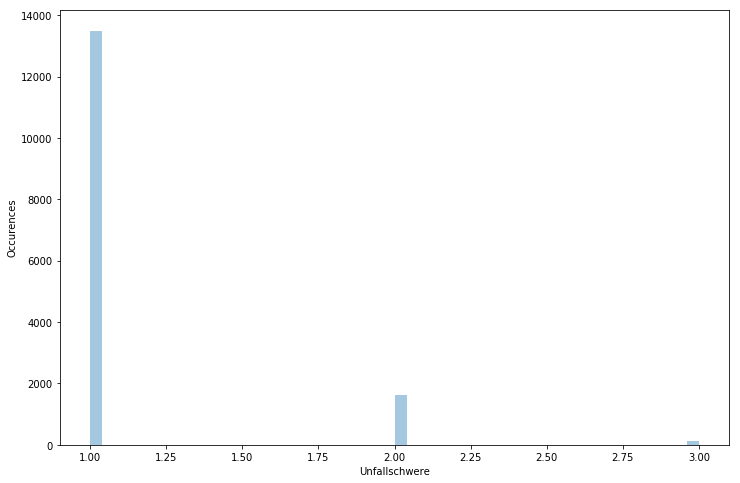

In [115]:
unfaelle = train_df["Unfallschwere"].values

plt.figure(figsize=(12, 8))
sns.distplot(unfaelle, kde=False)
plt.xlabel('Unfallschwere')
plt.ylabel('Occurences')
plt.show()

In [67]:
train_df["Unfallschwere"].value_counts()

1    13494
2     1618
3      108
Name: Unfallschwere, dtype: int64

<br>
<br>
Seems we have a quite unbalanced dataset in terms of the distribution of the target variable. It might be quite hard to predict the class '3' cases with so little examples of this class. Thus we might have to do something against this imbalance while training.
<br>
<br>

### Exploration of Features

We have a fairly small amount of features in the dataset, therefore we can make a little effort here to look deeper into those one by one and see if we can find some useful insights.



#### Feature 'Strassenklasse':

In [14]:
train_df['Strassenklasse'].unique()

train_df.groupby('Strassenklasse')['Strassenklasse'].count()

Strassenklasse
Autobahn                 899
Bundesstrasse           5733
Kraftfahrzeugstrasse     343
Landesstrasse            902
nicht klassifiziert     7330
unbefestigte Strasse      14
Name: Strassenklasse, dtype: int64

In [123]:
pd.crosstab(train_df["Unfallschwere"], train_df["Strassenklasse"], normalize=True, margins=True)

Strassenklasse,Autobahn,Bundesstrasse,Kraftfahrzeugstrasse,Landesstrasse,nicht klassifiziert,unbefestigte Strasse,All
Unfallschwere,,,,,,,
1,0.054070,0.333618,0.020892,0.052559,0.424676,0.000788,0.886604
2,0.004533,0.039616,0.001314,0.006504,0.054201,0.000131,0.106301
3,0.000460,0.003416,0.000328,0.000197,0.002694,0.000000,0.007095
All,0.059063,0.376651,0.022535,0.059260,0.481572,0.000920,1.000000


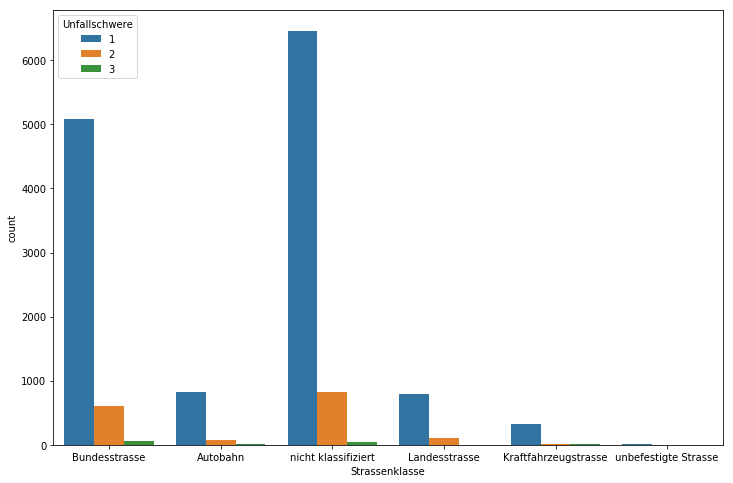

In [69]:
plt.figure(figsize=(12,8))

sns.countplot(x='Strassenklasse', hue='Unfallschwere', data=train_df)

So street types ('Strassenklasse') seem to be distributed equally within a class across all the classes of accident severity ('Unfallschwere'). Prior to this insight, we might have proposed the hypothesis that accident severity increases in numbers where people are allowed or tend to drive faster.

#### Feature 'Unfalldatum'

In [132]:
train_df["Unfalldatum"].unique()

array(['23. Jan.', '17-May-11', '14. Feb.', '31-Oct-12', '3. Nov.',
       '31-May-09', '24. Okt.', '25. Jul.', '7. Jan.', '10. Sep.',
       '21. Nov.', '26. Nov.', '10-Dec-09', '19-Dec-12', '09-Dec-11',
       '11. Okt.', '19. Jan.', '20-Oct-12', '15. Aug.', '15. Jun.',
       '24. Aug.', '14. Sep.', '07-Oct-11', '5. Jul.', '9. Sep.',
       '27. Sep.', '2. Feb.', '13. Feb.', '10. Apr.', '24. Feb.',
       '11-Dec-10', '28. Jun.', '31-May-12', '5. Nov.', '8. Aug.',
       '9. Jul.', '17-May-12', '9. Okt.', '01-Mar-11', '5. Jun.',
       '27. Apr.', '23. Aug.', '01-Oct-10', '13. Aug.', '27. Jul.',
       '18. Aug.', '23. Mai.', '4. Dez.', '31-Dec-12', '23. Sep.',
       '3. Jun.', '24-Dec-09', '20-May-09', '14. Mai.', '30-Dec-10',
       '14. Jun.', '2. Mai.', '17. Feb.', '24. Jun.', '22. Jul.',
       '31. Jul.', '28-Oct-09', '26. Okt.', '29. Jun.', '31. Okt.',
       '05-Oct-11', '10. Nov.', '21. Sep.', '7. Dez.', '11. Jan.',
       '8. Dez.', '06-Mar-12', '3. Aug.', '18. Jan.', '7.

In [130]:
test_df["Unfalldatum"].unique()

array(['8. Dez.', '29-May-10', '04-Mar-09', '11-May-09', '5. Apr.',
       '17. Jun.', '31. Dez.', '14. Sep.', '8. Feb.', '15. Nov.',
       '11. Feb.', '29-May-09', '2. Apr.', '12-Oct-12', '22. Apr.',
       '5. Jun.', '24. Feb.', '29-Oct-12', '08-Mar-11', '24. Mai.',
       '13. Jul.', '25. Aug.', '31-Mar-09', '31. Okt.', '6. Jun.',
       '23. Apr.', '12-Oct-09', '04-May-11', '30. Okt.', '3. Jul.',
       '21. Jun.', '8. Mai.', '15. Jun.', '20. Apr.', '19. Aug.',
       '22. Sep.', '30. Sep.', '9. Apr.', '24. Jul.', '26-May-09',
       '3. Aug.', '24. Aug.', '16. Jul.', '26. Sep.', '10-Mar-11',
       '1. Jun.', '16. Sep.', '15. Okt.', '27. Apr.', '20. Sep.',
       '21. Jan.', '11. Aug.', '20. Jul.', '21-Dec-12', '2. Jun.',
       '19. Jun.', '22. Nov.', '5. Nov.', '6. Feb.', '19. Mai.',
       '19-Oct-09', '19. Nov.', '16. Jun.', '8. Sep.', '9. Feb.',
       '8. Apr.', '18. Jul.', '1. Sep.', '13-Dec-09', '18-Mar-11',
       '11. Mai.', '25-Oct-09', '29. Sep.', '28. Sep.', '17. Jul

The Feature 'Unfalldatum' seems to be a tricky one to handle since we have a mixture of formatting styles of the dates. We have a mixture of separating the date representation, i.e. DD.MM.YYYY and DD-MM-YYYY which looks a mixture of german and american notation. Also it appears the month names are either abbreviated in german and english spelling. However, it appears that, although the american notation with dashes ('-') is used, the order of day, month and year is uniformly documented in the german style (DD-MM-YY instead of MM-DD-YY).

Moreover, we have an inconistency in documentation of the year in which the accidents happened. However, looking by the dates which do have the year documented, it seems that the data could comprise the years 2009-2012 and applies for both the training and the test data. So in order to squeeze more information out of this feature, we assume that the underlying data was captured between the years 2009-2012 and that the rows were randomly split into training and test data, thus we have no time-series analysis. 

<br>
Let's see if there are differences in the severity of accidents regarding the months:

In [14]:
#assume all incidents are from the same, arbitrary leapyear for the sake of plotting

dateconverted_df = train_df.copy()
dateconverted_df["Unfalldatum"] = dateconverted_df["Unfalldatum"].apply(lambda x: x[:x.rfind('-')] + '-2016') \
                                                 .apply(lambda x: x.replace(". ", "-")) \
                                                 .apply(lambda x: x.split('.', 1)[0])[:]


conversions = {"Mrz": "Mar",
               "Mai": "May",
               "Okt": "Oct",
               "Dez": "Dec"}

dateconverted_df["Unfalldatum"] = dateconverted_df["Unfalldatum"].replace(conversions, regex=True)



In [62]:
dateconverted_df["Unfalldatum"] = pd.to_datetime(dateconverted_df["Unfalldatum"], dayfirst=True)
#timeconverted_df.set_index('Unfalldatum', inplace = True)


In [118]:
pd.crosstab(dateconverted_df["Unfalldatum"].dt.month, dateconverted_df["Unfallschwere"], normalize=True, margins=True)

Unfallschwere,1,2,3,All
Unfalldatum,,,,
1,0.064976,0.008475,0.000460,0.073911
2,0.066750,0.008212,0.000197,0.075159
3,0.073977,0.008672,0.000460,0.083109
4,0.070889,0.007884,0.001051,0.079824
5,0.075554,0.008475,0.000591,0.084620
6,0.072926,0.008607,0.000394,0.081926
7,0.078050,0.009526,0.000854,0.088430
8,0.078247,0.009461,0.000657,0.088365
9,0.074174,0.009723,0.000526,0.084423


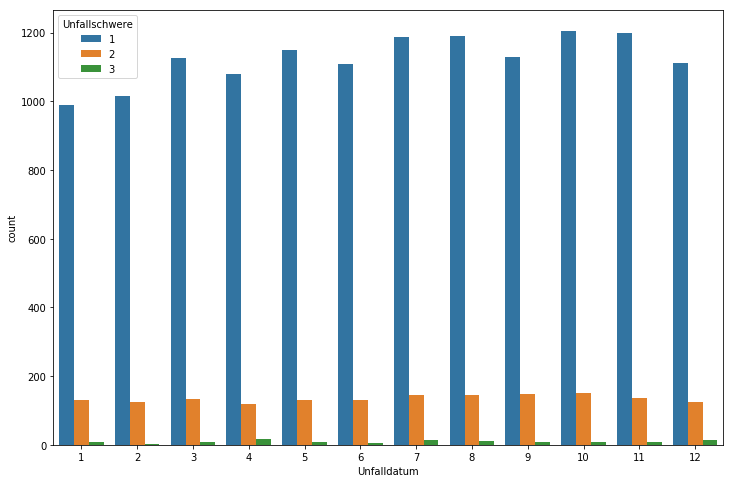

In [16]:
plt.figure(figsize=(12,8))

sns.countplot(x=dateconverted_df["Unfalldatum"].dt.month, hue=dateconverted_df['Unfallschwere'])

<br>
It's very hard to conclude something from the data and the plot as it seems that the accident severity is quite stable across the month in terms of numbers. There is a very slight move towards more severe accidents from the late summer months to December. One could hypothesize for the ending months of the year that the weather has an effect on the severity due to snow, glaze etc.. However, this wouldn't apply to the late summer months since there are different weather conditions but one might explain the more severe accidents by the probably increasing number of motorbikes on the street that tend to lead to more severe injuries when involved in an accident. We might verify this when we incorporate the "Fahrzeugtyp" column later.  

### Feature 'Alter'

Let's see what the age distribution regarding the incidents is:


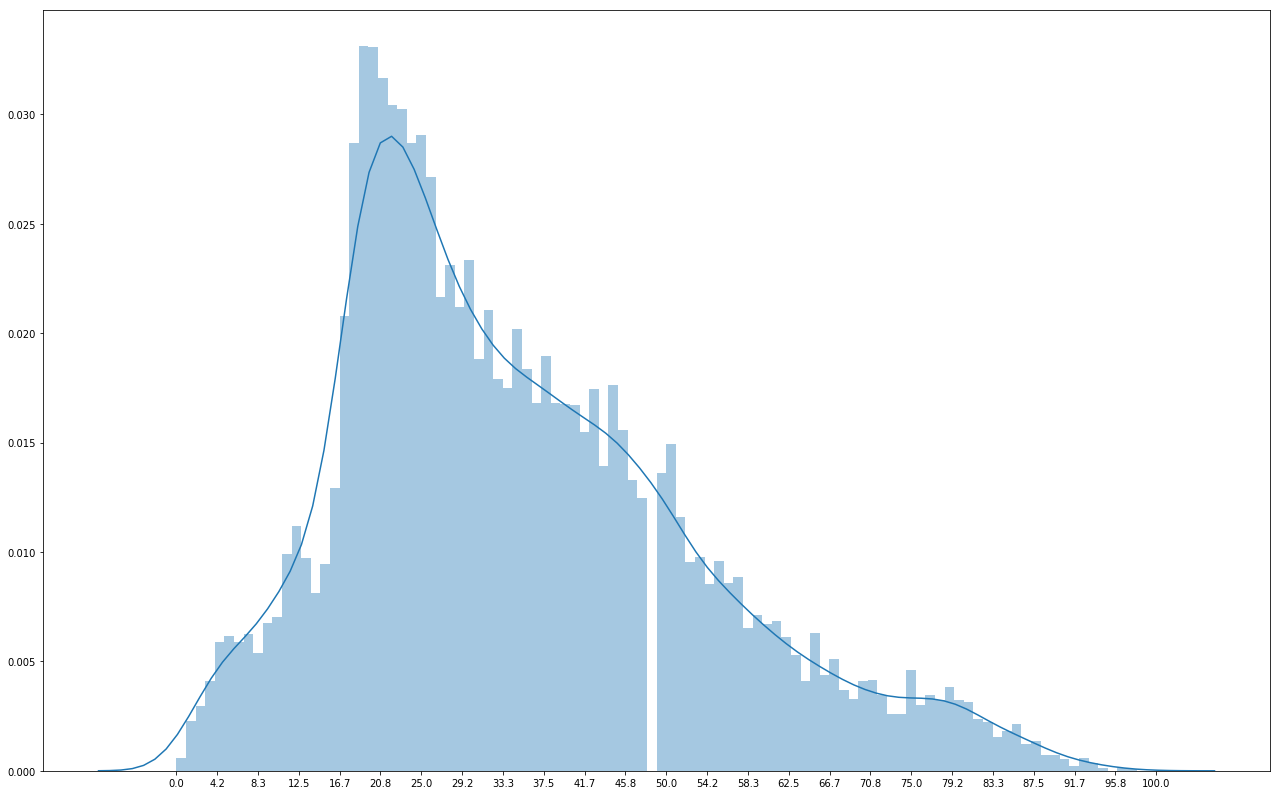

In [155]:
plt.figure(figsize=(22,14))
plt.xticks(np.linspace(start=0, stop=100, num=25))

sns.distplot(train_df["Alter"].values, bins=100)


So the age distribution is clearly skewed, that is most of the documented accidents involved people which are roughly in the age between 18 and 27 years. Also there a little bump at the end of the age scale, between 75 and 83 years. This is no surprise as one can argue that most accidents involve cars and that most accidents with cars happen when people either just started driving at the age of 18 (i.e. less experience) or when overestimating the ability to drive a car is a factor which can be the case for older people. 

Based on this insight, it would be good to know if the age is correlated with the severity of accidents in any way:

The box plot and the violin plot reveal that accidents tend to be more severe the older the person involved in the accident is. 

### Feature 'Unfallklasse'

In [35]:
num_fahrer = (train_df["Unfallklasse"] == "Fahrer").sum()
num_pass = (train_df["Unfallklasse"] == "Passagier").sum()
num_fuss = (train_df["Unfallklasse"] == "Fussgänger").sum()

print("Number of accidents with 'Fahrer': ", num_fahrer, "ratio: ", num_fahrer/train_df.shape[0])
print("Number of accidents with 'Passagier': ", num_pass, "ratio: ", num_pass/train_df.shape[0])
print("Number of accidents with 'Fussgänger': ", num_fuss, "ratio: ", num_fuss/train_df.shape[0])

Number of accidents with 'Fahrer':  8772 ratio:  0.5763090467117797
Number of accidents with 'Passagier':  4310 ratio:  0.2831614217199921
Number of accidents with 'Fussgänger':  2139 ratio:  0.14052953156822812


<br>
<br>
So in about more than half of the accidents drivers were injured, whereas pedestrians is the smallest group of injured people in this dataset

Let's see if accident severity is related to the 'type' of person that was injured in the accident
<br>
<br>

In [28]:
pd.crosstab(train_df["Unfallschwere"], train_df["Unfallklasse"], normalize=True, margins=True)

Unfallklasse,Fahrer,Fussgänger,Passagier,All
Unfallschwere,,,,
1,0.515998,0.105184,0.265423,0.886604
2,0.056829,0.032981,0.016490,0.106301
3,0.003482,0.002365,0.001248,0.007095
All,0.576309,0.140530,0.283161,1.000000


From the contigency table it seems that for the classes 'Fahrer' and 'Passagier' the most dominant injury is of severity 1. However, the severity of the class 'Fussgänger' no real predominant injury class. 

We might see this better with a graph:

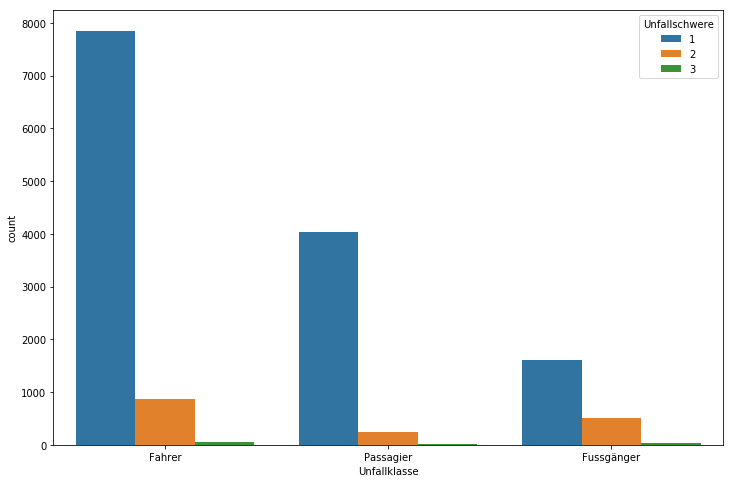

In [68]:
plt.figure(figsize=(12,8))
sns.countplot(x="Unfallklasse", hue='Unfallschwere', data=train_df)

The histogram makes it clear that there's a big shift in terms of severity regarding the injuries, when the injured person is a pedestrian. Meaning: So in about 85% of the cases where drivers are injured, the severity class will be 1, whereas in the case of a pedestrian it is almost a flip coin if the pedestrian's severity is class 1 or class 2/3 (cases of class 2 and 3 accumulated).

If there's time left, we could investigate the relation between 'Unfallklasse' and severity of the accidents further, e.g. together with a third feature for example the day time in order to see if injuries for pedestrians at night time are more severe than during the day.

### Feature 'Lichtverhältnisse'

In [3]:
train_df["Lichtverhältnisse"].unique()

array(['Tageslicht: Strassenbeleuchtung vorhanden',
       'Dunkelheit: Strassenbeleuchtung vorhanden und beleuchtet',
       'Dunkelheit: keine Strassenbeleuchtung',
       'Dunkelheit: Strassenbeleuchtung unbekannt',
       'Dunkelheit: Strassenbeleuchtung vorhanden und nicht beleuchtet'],
      dtype=object)

Regarding the light conditions during the accidents it's fair to assume that injuries are more severe when these are poor due to longer reaction times etc.. Let's confirm if this is true for the dataset:

In [17]:
pd.crosstab(train_df["Lichtverhältnisse"], train_df["Unfallschwere"], margins=True)

Unfallschwere,1,2,3,All
Lichtverhältnisse,,,,
Dunkelheit: Strassenbeleuchtung unbekannt,1165,137,9,1311
Dunkelheit: Strassenbeleuchtung vorhanden und beleuchtet,2713,398,31,3142
Dunkelheit: Strassenbeleuchtung vorhanden und nicht beleuchtet,27,7,0,34
Dunkelheit: keine Strassenbeleuchtung,211,37,8,256
Tageslicht: Strassenbeleuchtung vorhanden,9379,1039,60,10478
All,13495,1618,108,15221


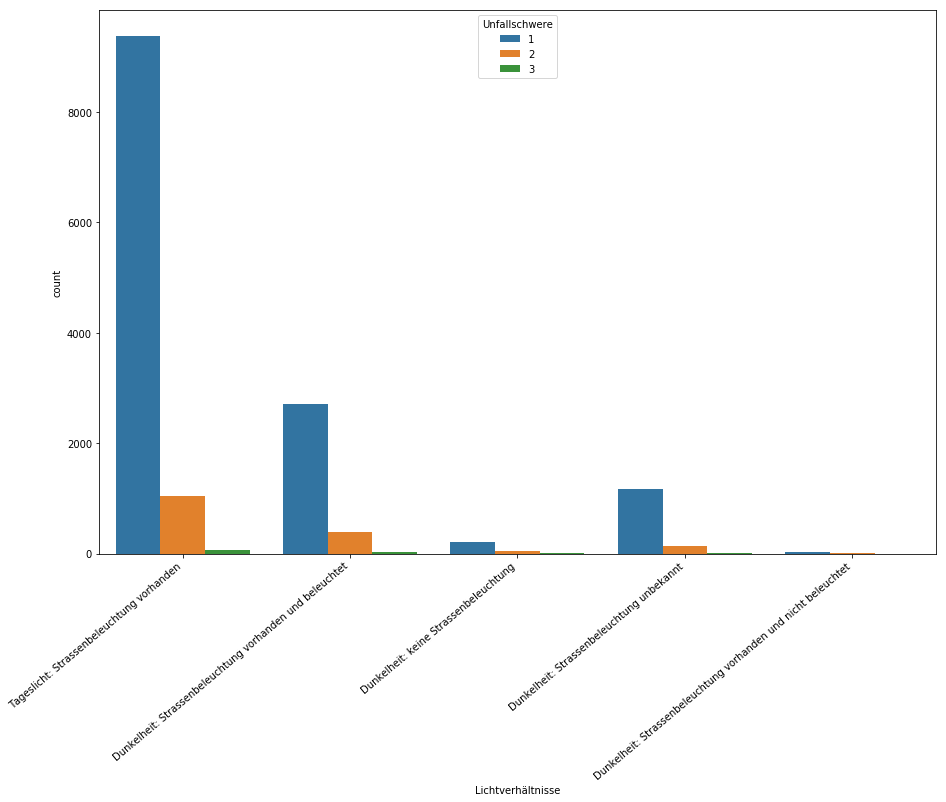

In [18]:
plt.figure(figsize=(15,10))

ax = sns.countplot(x="Lichtverhältnisse", hue="Unfallschwere", data=train_df)

ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.show()

Surprisingly our assumption is really hard to satisfy as the distribution of the severity cases seem to be equal across the lightning conditions. So we might even consider dropping this Feature in the training process, especially as in ~10% of the accidents the lightning conditions is unknown and the information gain out of these examples might not be existent.

### Feature 'Verletzte Personen'

There's probably no direct relation between the number of injured people and the severity of the injury. Moreover, it's not clear how this feature fits into the documentation of an injury case, since assuming from all the other features that are documented per row, it seems that one row is related to the accident and injury of one person. Therefore, it's hard to tell how to use this information in advance 

However, let's see how

In [28]:
np.sort(train_df["Verletzte Personen"].unique())

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [29]:
np.sort(test_df["Verletzte Personen"].unique())

array([ 1,  2,  3,  4,  5,  6,  7,  8, 11, 12])

In [32]:
train_df[train_df["Verletzte Personen"] == 12]

,Strassenklasse,Unfalldatum,Alter,Unfallklasse,Unfallschwere,Lichtverhältnisse,Verletzte Personen,Anzahl Fahrzeuge,Bodenbeschaffenheit,Geschlecht,Zeit (24h),Fahrzeugtyp,Wetterlage
3489,Autobahn,25. Jul.,34,Passagier,2,Tageslicht: Strassenbeleuchtung vorhanden,12,1,trocken,männlich,1350,Kleinbus,Gut
4676,Autobahn,25. Jul.,36,Passagier,2,Tageslicht: Strassenbeleuchtung vorhanden,12,1,trocken,männlich,1350,Kleinbus,Gut
5109,Autobahn,25. Jul.,29,Passagier,2,Tageslicht: Strassenbeleuchtung vorhanden,12,1,trocken,männlich,1350,Kleinbus,Gut
5564,Autobahn,25. Jul.,42,Passagier,2,Tageslicht: Strassenbeleuchtung vorhanden,12,1,trocken,männlich,1350,Kleinbus,Gut
6032,Autobahn,25. Jul.,65,Passagier,1,Tageslicht: Strassenbeleuchtung vorhanden,12,1,trocken,männlich,1350,Kleinbus,Gut
8336,Autobahn,25. Jul.,37,Passagier,1,Tageslicht: Strassenbeleuchtung vorhanden,12,1,trocken,männlich,1350,Kleinbus,Gut
8730,Autobahn,25. Jul.,46,Fahrer,2,Tageslicht: Strassenbeleuchtung vorhanden,12,1,trocken,männlich,1350,Kleinbus,Gut
9641,Autobahn,25. Jul.,27,Passagier,1,Tageslicht: Strassenbeleuchtung vorhanden,12,1,trocken,männlich,1350,Kleinbus,Gut
11967,Autobahn,25. Jul.,55,Passagier,2,Tageslicht: Strassenbeleuchtung vorhanden,12,1,trocken,männlich,1350,Kleinbus,Gut
12844,Autobahn,25. Jul.,67,Passagier,1,Tageslicht: Strassenbeleuchtung vorhanden,12,1,trocken,männlich,1350,Kleinbus,Gut


It seems that the dataset documents every injury of a person individually, as already assumed. So for 'larger' accidents, there can be several instances of this accident which obviously share most of the same feature values.

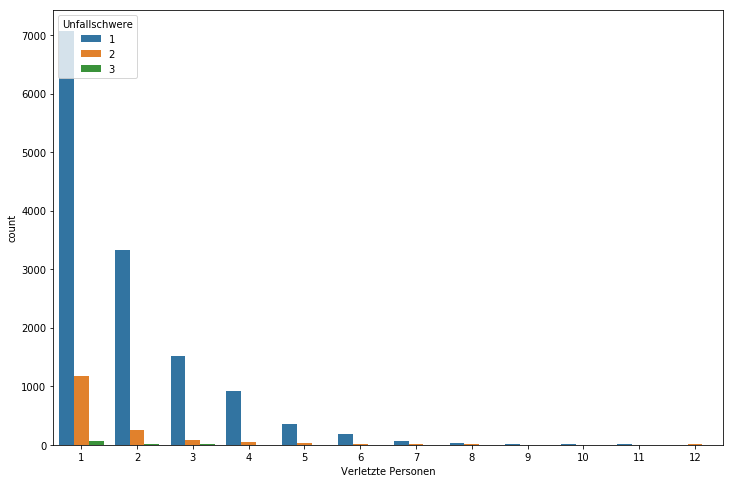

In [20]:
plt.figure(figsize=(12,8))
sns.countplot(x="Verletzte Personen", hue='Unfallschwere', data=train_df)

In [21]:
pd.crosstab(train_df["Verletzte Personen"], train_df["Unfallschwere"])

Unfallschwere,1,2,3
Verletzte Personen,,,
1,7075,1169,63
2,3323,253,20
3,1517,81,15
4,915,45,3
5,360,34,5
6,180,12,0
7,58,6,2
8,27,10,0
9,17,1,0


In [80]:
train_df[train_df["Verletzte Personen"] == 12]

,Strassenklasse,Unfalldatum,Alter,Unfallklasse,Unfallschwere,Lichtverhältnisse,Verletzte Personen,Anzahl Fahrzeuge,Bodenbeschaffenheit,Geschlecht,Zeit,Fahrzeugtyp,Wetterlage
3489,Autobahn,25. Jul.,34,Passagier,2,Tageslicht: Strassenbeleuchtung vorhanden,12,1,trocken,männlich,1350,Kleinbus,Gut
4676,Autobahn,25. Jul.,36,Passagier,2,Tageslicht: Strassenbeleuchtung vorhanden,12,1,trocken,männlich,1350,Kleinbus,Gut
5109,Autobahn,25. Jul.,29,Passagier,2,Tageslicht: Strassenbeleuchtung vorhanden,12,1,trocken,männlich,1350,Kleinbus,Gut
5564,Autobahn,25. Jul.,42,Passagier,2,Tageslicht: Strassenbeleuchtung vorhanden,12,1,trocken,männlich,1350,Kleinbus,Gut
6032,Autobahn,25. Jul.,65,Passagier,1,Tageslicht: Strassenbeleuchtung vorhanden,12,1,trocken,männlich,1350,Kleinbus,Gut
8336,Autobahn,25. Jul.,37,Passagier,1,Tageslicht: Strassenbeleuchtung vorhanden,12,1,trocken,männlich,1350,Kleinbus,Gut
8730,Autobahn,25. Jul.,46,Fahrer,2,Tageslicht: Strassenbeleuchtung vorhanden,12,1,trocken,männlich,1350,Kleinbus,Gut
9641,Autobahn,25. Jul.,27,Passagier,1,Tageslicht: Strassenbeleuchtung vorhanden,12,1,trocken,männlich,1350,Kleinbus,Gut
11967,Autobahn,25. Jul.,55,Passagier,2,Tageslicht: Strassenbeleuchtung vorhanden,12,1,trocken,männlich,1350,Kleinbus,Gut
12844,Autobahn,25. Jul.,67,Passagier,1,Tageslicht: Strassenbeleuchtung vorhanden,12,1,trocken,männlich,1350,Kleinbus,Gut


In [81]:
test_df[test_df["Verletzte Personen"] == 12]

,Strassenklasse,Unfalldatum,Alter,Unfallklasse,Lichtverhältnisse,Verletzte Personen,Anzahl Fahrzeuge,Bodenbeschaffenheit,Geschlecht,Zeit (24h),Fahrzeugtyp,Wetterlage
160,Autobahn,25. Jul.,31,Passagier,Tageslicht: Strassenbeleuchtung vorhanden,12,1,trocken,männlich,1350,Kleinbus,Gut
505,Autobahn,25. Jul.,34,Passagier,Tageslicht: Strassenbeleuchtung vorhanden,12,1,trocken,männlich,1350,Kleinbus,Gut


So the feature 'Verletzte Personen' can serve a linkage feature between instances of accidents, i.e. if the number of injured people are the same and most of the other feature value are equal (especially date and time) it can be used as a linkage feature. Other than that, it seems hard to gain any other information out of this feature that could have an impact on the outcome of the injury severity. 

Also for some accidents the injured persons of the same accidents were split up between the training and the test set. However, at the moment there's no idea on how this information could be used to benefit the prediction model. 

#### Feature 'Anzahl Fahrzeuge'

This feature likely to be the same type of feature as the 'Verletzte Personen' feature that means there's is likely to be no further information regarding injury severity.

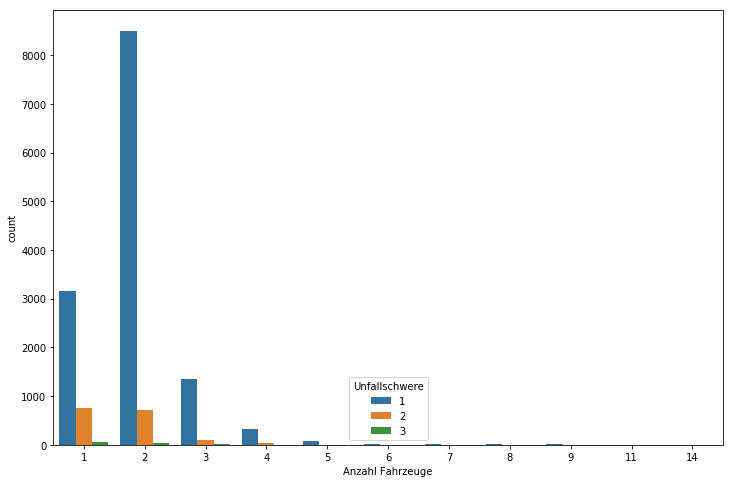

In [33]:
plt.figure(figsize=(12,8))
sns.countplot(x="Anzahl Fahrzeuge", hue='Unfallschwere', data=train_df)

In [3]:
pd.crosstab(train_df["Anzahl Fahrzeuge"], train_df["Unfallschwere"], normalize=True, margins=True)

Unfallschwere,1,2,3,All
Anzahl Fahrzeuge,,,,
1,0.207214,0.049865,0.003154,0.260233
2,0.558702,0.047500,0.002694,0.608896
3,0.088693,0.006110,0.000920,0.095723
4,0.021812,0.001774,0.000066,0.023652
5,0.005716,0.000394,0.000131,0.006241
6,0.001511,0.000328,0.000131,0.001971
7,0.000985,0.000131,0.000000,0.001117
8,0.000591,0.000197,0.000000,0.000788
9,0.000788,0.000000,0.000000,0.000788


Except a large of number class 1 injuries for the accidents where two vehicles are involved, there doesn't seem to be an obvious pattern between number of involded vehicles and injury severity.

### Feature 'Bodenbeschaffenheit'

In [6]:
train_df["Bodenbeschaffenheit"].unique()

array(['trocken', 'nass / feucht', 'Schnee', 'Frost / Eis', 'Frost/ Ice',
       'Überflutung', '9'], dtype=object)

In [58]:
#We might need to remove this row
train_df[train_df["Bodenbeschaffenheit"] == "9"]


,Strassenklasse,Unfalldatum,Alter,Unfallklasse,Unfallschwere,Lichtverhältnisse,Verletzte Personen,Anzahl Fahrzeuge,Bodenbeschaffenheit,Geschlecht,Zeit,Fahrzeugtyp,Wetterlage
9380,nicht klassifiziert,27. Nov.,40,Fahrer,1,Dunkelheit: Strassenbeleuchtung unbekannt,1,2,9,männlich,2005,Auto,Unbekannt


In [59]:
train_df.drop(train_df.index[9380], inplace=True)

In [60]:
#Converting 'Frost/ Ice' to 'Frost / Eis'
train_df["Bodenbeschaffenheit"].replace("Frost/ Ice", "Frost / Eis", inplace=True)

It's fair to assume that the injuries are more severe when driving conditions are worse. Again, we should confirm this 

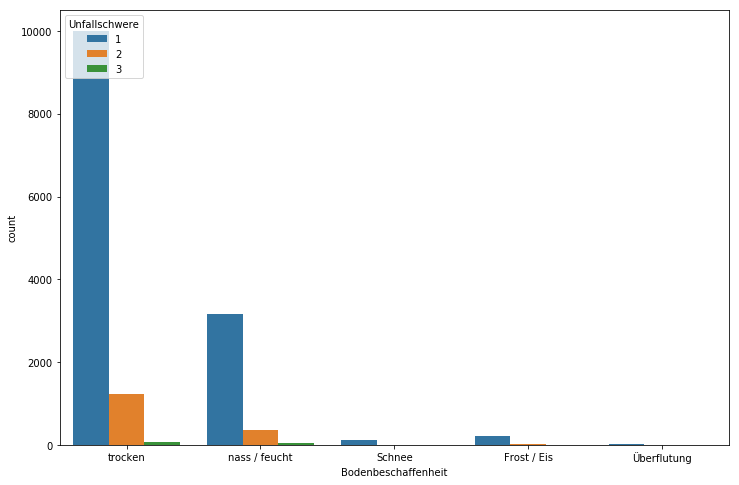

In [24]:
plt.figure(figsize=(12,8))
sns.countplot(x="Bodenbeschaffenheit", hue='Unfallschwere', data=train_df)

In [25]:
pd.crosstab(train_df["Bodenbeschaffenheit"], train_df["Unfallschwere"], margins=True)

Unfallschwere,1,2,3,All
Bodenbeschaffenheit,,,,
Frost / Eis,206,24,0,230
Schnee,119,7,0,126
nass / feucht,3153,361,41,3555
trocken,10005,1226,67,11298
Überflutung,11,0,0,11
All,13494,1618,108,15220


The distrubtion of severity cases seem to be equal between the classes of driving conditions. However, this temporary insight has to be taken with caution. For example, the numbers could be biased in favor for the mild injury severity cases for the worse driving conditions (i.e. rain, snow, glaze) because it can be assumed that people don't ride their motorbikes during such conditions and accidents involving motorbikes tend to be more severe in general. If there's time, we can check this further by incorporating the feature 'Fahrzeugklasse' into this analysis.

### Feature 'Geschlecht'

It's hard to formulate a prior between the relationship between the gender of the injured person and its injury accident. So we'll just explore the distribution:

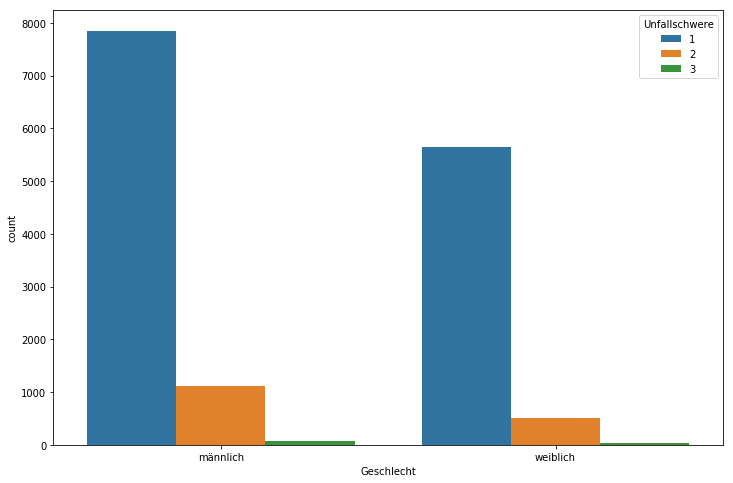

In [26]:
plt.figure(figsize=(12,8))
sns.countplot(x="Unfallschwere", hue='Unfallschwere', data=train_df)

In [29]:
pd.crosstab(train_df["Geschlecht"], train_df["Unfallschwere"], margins=True)

Unfallschwere,1,2,3,All
Geschlecht,,,,
männlich,7854,1112,79,9045
weiblich,5640,506,29,6175
All,13494,1618,108,15220


Male people tend to get slightly more severly injured, however this difference is probably neglectable.

### Feature 'Zeit'

In [3]:
#Convert time to a datetime together with the date
train_df.rename(columns={"Zeit (24h)": "Zeit"}, inplace=True)

In [20]:
train_df.head(10)

,Strassenklasse,Unfalldatum,Alter,Unfallklasse,Unfallschwere,Lichtverhältnisse,Verletzte Personen,Anzahl Fahrzeuge,Bodenbeschaffenheit,Geschlecht,Zeit,Fahrzeugtyp,Wetterlage
0,Bundesstrasse,23. Jan.,59,Fahrer,1,Tageslicht: Strassenbeleuchtung vorhanden,2,2,trocken,männlich,1330,LKW ab 7.5t,Gut
1,Autobahn,17-May-11,48,Fahrer,1,Tageslicht: Strassenbeleuchtung vorhanden,2,4,trocken,weiblich,1724,Auto,Gut
2,nicht klassifiziert,14. Feb.,56,Fahrer,2,Tageslicht: Strassenbeleuchtung vorhanden,1,1,nass / feucht,männlich,1345,Mottorrad (500cc),Gut
3,Bundesstrasse,31-Oct-12,66,Fahrer,1,Dunkelheit: Strassenbeleuchtung vorhanden und ...,3,2,nass / feucht,weiblich,1830,Auto,Regen
4,Bundesstrasse,3. Nov.,33,Fahrer,2,Dunkelheit: keine Strassenbeleuchtung,1,1,nass / feucht,männlich,15,Auto,Gut
5,nicht klassifiziert,31-May-09,72,Passagier,1,Tageslicht: Strassenbeleuchtung vorhanden,4,2,trocken,weiblich,1457,Auto,Gut
6,Bundesstrasse,24. Okt.,62,Fahrer,1,Tageslicht: Strassenbeleuchtung vorhanden,1,2,trocken,männlich,1130,Fahrrad,Gut
7,nicht klassifiziert,25. Jul.,45,Fahrer,1,Tageslicht: Strassenbeleuchtung vorhanden,2,2,trocken,männlich,1520,Transporter,Gut
8,Bundesstrasse,7. Jan.,66,Passagier,2,Tageslicht: Strassenbeleuchtung vorhanden,2,2,Schnee,weiblich,1057,Auto,Schnee
9,Bundesstrasse,10. Sep.,67,Fahrer,1,Tageslicht: Strassenbeleuchtung vorhanden,2,3,trocken,weiblich,1300,Auto,Gut


In [22]:
train_df["Zeit"].value_counts()

1730    165
1600    159
1800    142
1700    139
1630    123
1430    120
1530    115
1500    113
1830    112
1720    108
1330    106
1740    105
1745    103
1900    100
800      98
1300     96
830      92
1200     90
1645     89
1610     88
845      86
1520     85
1515     85
1640     84
1340     84
840      81
1510     81
1230     81
1710     81
1545     81
       ... 
1222      1
2346      1
1318      1
2051      1
2319      1
619       1
1211      1
201       1
924       1
1921      1
14        1
22        1
2111      1
2119      1
2127      1
1929      1
118       1
2128      1
2303      1
126       1
134       1
1251      1
748       1
2207      1
603       1
2247      1
2032      1
214       1
246       1
946       1
Name: Zeit, Length: 1168, dtype: int64

It's not quite clear if the time column is correctly documented. E.g. for the row with index number 5 the incident seems to be documented at 3 pm but the lightning conditions were documented as darkish. Moreover, the granularity of the documented seems to vary, that is, mostly the time was documented by hour and minutes but there are also cases where the minutes seem to have been dropped and the hour is shortened to one character. 

We need to check how often these problems occur in the dataset.

In [46]:
"""for the sake of simplicity, we will assume that the lightning conditions for the time between 6am-5.59pm 
   should be light, whereas from 6pm-5.59am should be dark"""

timeformat_counts = train_df["Zeit"].astype(str).str.len().value_counts()
print(timeformat_counts)

4    11806
3     3106
2      239
1       70
Name: Zeit, dtype: int64


It seems the time feature is not documented accurately, as we have 30 rows where only one character for the time recorded, making it a problem which we need to deal with. It probably would be a hard assumption to treat and convert the one character time according to the lightning conditions. E.g. '8' for dark lightning conditions would be converted to 8pm, whereas in bright lightning conditions this would equal to 8am. However, this is probably hard to justify for the winter months, as 5am the lightning conditions are as dark as the lightning conditions at 5pm. 

Therefore, we are probably better advised to drop the 70 accidents with the one character time feature.

In [76]:
train_df[(train_df["Zeit"].astype(str).str.len() == 2)][:5]

,Strassenklasse,Unfalldatum,Alter,Unfallklasse,Unfallschwere,Lichtverhältnisse,Verletzte Personen,Anzahl Fahrzeuge,Bodenbeschaffenheit,Geschlecht,Zeit,Fahrzeugtyp,Wetterlage
4,Bundesstrasse,3. Nov.,33,Fahrer,2,Dunkelheit: keine Strassenbeleuchtung,1,1,nass / feucht,männlich,15,Auto,Gut
42,Bundesstrasse,23. Aug.,14,Passagier,1,Dunkelheit: Strassenbeleuchtung vorhanden und ...,8,2,trocken,weiblich,45,Auto,Gut
45,Bundesstrasse,27. Jul.,29,Fussgänger,2,Dunkelheit: Strassenbeleuchtung vorhanden und ...,1,1,nass / feucht,männlich,54,Auto,Regen
68,Bundesstrasse,26. Okt.,17,Passagier,1,Dunkelheit: Strassenbeleuchtung vorhanden und ...,7,2,trocken,männlich,29,Auto,Gut
331,nicht klassifiziert,13. Jan.,21,Passagier,1,Dunkelheit: Strassenbeleuchtung vorhanden und ...,5,2,nass / feucht,weiblich,25,Auto,Gut


In [71]:
train_df[(train_df["Zeit"].astype(str).str.len() == 2) & (train_df["Lichtverhältnisse"].str.match("Tageslicht"))]

,Strassenklasse,Unfalldatum,Alter,Unfallklasse,Unfallschwere,Lichtverhältnisse,Verletzte Personen,Anzahl Fahrzeuge,Bodenbeschaffenheit,Geschlecht,Zeit,Fahrzeugtyp,Wetterlage
2499,nicht klassifiziert,19. Okt.,26,Fahrer,1,Tageslicht: Strassenbeleuchtung vorhanden,1,2,trocken,weiblich,15,Fahrrad,Gut


In [74]:
train_df[(train_df["Zeit"].astype(str).str.len() == 3)][:10]

,Strassenklasse,Unfalldatum,Alter,Unfallklasse,Unfallschwere,Lichtverhältnisse,Verletzte Personen,Anzahl Fahrzeuge,Bodenbeschaffenheit,Geschlecht,Zeit,Fahrzeugtyp,Wetterlage
10,Landesstrasse,21. Nov.,12,Fussgänger,1,Tageslicht: Strassenbeleuchtung vorhanden,1,1,trocken,weiblich,835,Auto,Gut
18,nicht klassifiziert,15. Aug.,26,Passagier,2,Dunkelheit: Strassenbeleuchtung vorhanden und ...,2,2,trocken,männlich,422,Auto,Gut
32,Bundesstrasse,28. Jun.,27,Fahrer,1,Tageslicht: Strassenbeleuchtung vorhanden,2,1,trocken,weiblich,855,Auto,Gut
38,Bundesstrasse,9. Okt.,57,Fahrer,1,Dunkelheit: Strassenbeleuchtung vorhanden und ...,1,2,trocken,weiblich,713,Auto,Gut
48,Bundesstrasse,20-Oct-12,44,Fahrer,2,Tageslicht: Strassenbeleuchtung vorhanden,2,2,trocken,männlich,830,Auto,Gut
49,nicht klassifiziert,10. Apr.,50,Fahrer,1,Tageslicht: Strassenbeleuchtung vorhanden,2,3,trocken,männlich,810,Mottorrad (500cc),Gut
50,nicht klassifiziert,25. Jul.,51,Fahrer,2,Tageslicht: Strassenbeleuchtung vorhanden,1,2,trocken,männlich,935,Fahrrad,Gut
51,Bundesstrasse,23. Mai.,21,Fahrer,1,Tageslicht: Strassenbeleuchtung vorhanden,1,2,trocken,männlich,904,Fahrrad,Gut
56,Autobahn,24-Dec-09,24,Fahrer,1,Dunkelheit: Strassenbeleuchtung vorhanden und ...,1,1,Schnee,männlich,702,Auto,Schnee
60,Bundesstrasse,30-Dec-10,40,Fahrer,1,Tageslicht: Strassenbeleuchtung vorhanden,1,3,nass / feucht,weiblich,848,Auto,Gut


In [69]:
train_df[["Unfalldatum", "Zeit"]][(train_df["Lichtverhältnisse"].str.match("Tageslicht")) &
                                 (train_df["Zeit"].astype(str).str.len() == 3)]

,Unfalldatum,Zeit
10,21. Nov.,835
32,28. Jun.,855
48,20-Oct-12,830
49,10. Apr.,810
50,25. Jul.,935
51,23. Mai.,904
60,30-Dec-10,848
64,24. Jun.,600
67,28-Oct-09,730
73,21. Sep.,910


In [70]:
train_df[["Unfalldatum", "Zeit"]][(train_df["Lichtverhältnisse"].str.match("Dunkelheit")) &
                                 (train_df["Zeit"].astype(str).str.len() == 3)]

,Unfalldatum,Zeit
18,15. Aug.,422
38,9. Okt.,713
56,24-Dec-09,702
75,11. Jan.,210
111,19-Dec-09,700
122,13. Okt.,143
137,27-Mar-12,730
144,30-May-09,145
154,1. Jun.,131
157,19. Sep.,245


For the 2 and 3 character time representation it appears that the 2 and 1, resprectively, preceded 0s were dropped. This might be due to the formatting of the used software program (probably excel) that drops preceding 0s for integers if a non-appropriate formatting style is chosen beforehand.
This is especially visible for the 2 character representation of the time feature which, except one row (that needs to be filtered out), have a dark lightning condition. Therefore, these incidents were likely happening between 0.00am-0.59am.

Obviously, this rule also applies for the 3 character time representations, as the recorded times seem to match the lightning conditions. 

In [29]:
#convert string time feature to datetime format
timeconverted_df = train_df.copy()

def append_zeros(x):
    if len(str(x)) == 3:
        return "0" + str(x)[0] + ":" + str(x)[-2:]
    if len(str(x)) == 2:
        return "00:" + str(x)
    if len(str(x)) == 4:
        return str(x)[:2] + ":" + str(x)[-2:]
    
timeconverted_df["Zeit"] = timeconverted_df["Zeit"].apply(append_zeros)
timeconverted_df["Zeit"] = pd.to_datetime(timeconverted_df["Zeit"], format="%H:%M")
                                                         


<Figure size 1440x1440 with 0 Axes>

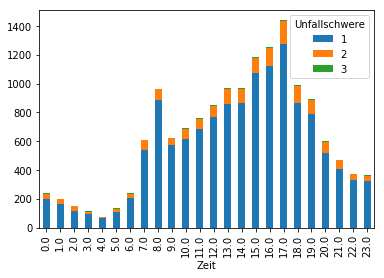

In [35]:
stacked_data = pd.crosstab(timeconverted_df["Zeit"].dt.hour, timeconverted_df['Unfallschwere'])

plt.figure(figsize=(20,20))
stacked_data.plot.bar(stacked=True)

plt.show()

If we fix the recorded times for the accidents to hours only and make a plot against the counts of accidents according to the severity classes for each hour, we see that there's no real predominant hour or time range where accidents to be more severe or less severe. We might have to see which of the date and time features are necessary and which ones can be excluded since there are several features that, to some extent, relate to the time of the incidents.

### Feature 'Fahrzeugtyp'

In [38]:
train_df["Fahrzeugtyp"].unique()

array(['LKW ab 7.5t', 'Auto', 'Mottorrad (500cc)', 'Fahrrad',
       'Transporter', 'Bus', 'Mottorrad (50cc)', 'Taxi', 'Mottorrad',
       'Mottorrad (125cc)', 'Kleinbus', 'Andere', 'Unbekannt',
       'LKW bis 7.5t', 'Pferd', 'Traktor', '97'], dtype=object)

In [41]:
train_df["Fahrzeugtyp"].value_counts()

Auto                 10376
Fahrrad               1567
Bus                   1021
Taxi                   556
Mottorrad (50cc)       449
Transporter            367
Mottorrad (500cc)      350
Mottorrad (125cc)      134
Mottorrad              127
Andere                  93
Kleinbus                64
LKW ab 7.5t             64
LKW bis 7.5t            35
Traktor                  6
Pferd                    6
Unbekannt                4
97                       2
Name: Fahrzeugtyp, dtype: int64

In [42]:
test_df["Fahrzeugtyp"].value_counts()

Auto                 668
Fahrrad               97
Bus                   66
Taxi                  36
Transporter           35
Mottorrad (50cc)      28
Mottorrad (500cc)     26
Mottorrad             14
Mottorrad (125cc)      9
Andere                 7
Kleinbus               7
LKW bis 7.5t           4
LKW ab 7.5t            2
97                     1
Name: Fahrzeugtyp, dtype: int64

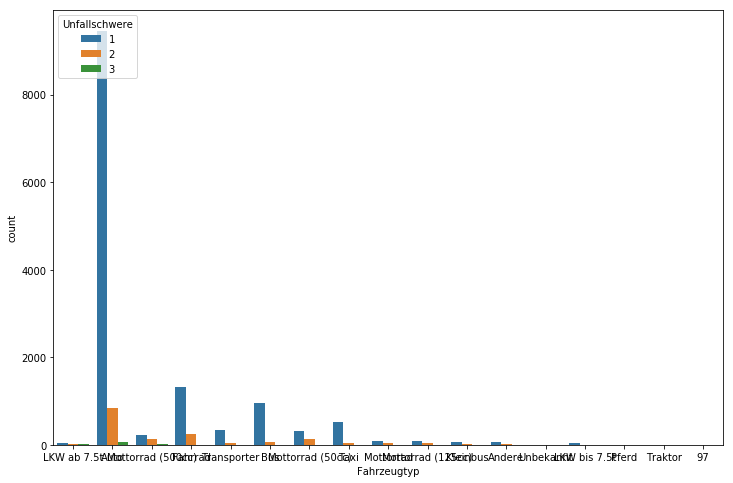

In [43]:
plt.figure(figsize=(12,8))
sns.countplot(x="Fahrzeugtyp", hue='Unfallschwere', data=train_df)

In [51]:
pd.crosstab(train_df["Fahrzeugtyp"], train_df["Unfallschwere"], margins=True, normalize='index')

Unfallschwere,1,2,3
Fahrzeugtyp,,,
97,0.500000,0.500000,0.000000
Andere,0.795699,0.193548,0.010753
Auto,0.912008,0.081920,0.006072
Bus,0.925563,0.068560,0.005877
Fahrrad,0.845565,0.151883,0.002553
Kleinbus,0.843750,0.156250,0.000000
LKW ab 7.5t,0.640625,0.218750,0.140625
LKW bis 7.5t,0.857143,0.142857,0.000000
Mottorrad,0.755906,0.244094,0.000000


We got a pretty diverse collection of values for the vehicle type. Some of which are only occur a few times in the training set and are vanishing completely in the test set. We probably need to remove the rows with the non-occuring values in the test set, as they might introduce to much 'noise'. 

### Feature 'Wetterlage'

In [61]:
train_df["Wetterlage"].unique()

array(['Gut', 'Regen', 'Schnee', 'Regen (starker Wind)',
       'Gut (starker Wind)', 'Unbekannt', 'Schnee (starker Wind)',
       'Andere', 'Nebel'], dtype=object)

In [62]:
train_df["Wetterlage"].value_counts()

Gut                      13229
Regen                     1296
Gut (starker Wind)         175
Regen (starker Wind)       157
Schnee                     118
Andere                     116
Unbekannt                   74
Nebel                       48
Schnee (starker Wind)        7
Name: Wetterlage, dtype: int64

In [63]:
test_df["Wetterlage"].value_counts()

Gut                     883
Regen                    73
Gut (starker Wind)       16
Regen (starker Wind)     11
Unbekannt                 6
Andere                    5
Schnee                    4
Nebel                     2
Name: Wetterlage, dtype: int64

In [64]:
pd.crosstab(train_df["Wetterlage"], train_df["Bodenbeschaffenheit"])

Bodenbeschaffenheit,Frost / Eis,Schnee,nass / feucht,trocken,Überflutung
Wetterlage,,,,,
Andere,29,9,68,10,0
Gut,159,34,1907,11128,1
Gut (starker Wind),5,0,79,91,0
Nebel,1,1,42,4,0
Regen,19,0,1256,15,6
Regen (starker Wind),1,0,151,1,4
Schnee,14,78,26,0,0
Schnee (starker Wind),1,4,2,0,0
Unbekannt,1,0,24,49,0


In [65]:
pd.crosstab(test_df["Wetterlage"], test_df["Bodenbeschaffenheit"])

Bodenbeschaffenheit,Frost / Eis,Frost/ Ice,Schnee,nass / feucht,trocken,Überflutung
Wetterlage,,,,,,
Andere,0,1,0,4,0,0
Gut,7,6,2,144,723,1
Gut (starker Wind),0,0,0,9,7,0
Nebel,1,0,0,1,0,0
Regen,0,0,0,72,1,0
Regen (starker Wind),0,0,0,10,1,0
Schnee,0,0,4,0,0,0
Unbekannt,0,0,0,2,4,0


Again, we got a diverse collection of values. For this feature it is unclear if it can provide any more information than the feature 'Bodenbeschaffenheit' since they are obviously highly correlated in some way. Moreover, we got about ~200 values that have no further information like 'Andere' and 'Unbekannt'. According to the contigancy table each of these values have a predominant class regarding the 'Bodenbeschaffenheit'. In order not lose all the rows, we might go ahead and strictly map these values to the other 'Wetterlage' values which correspond to the majority of the 'Bodenbeschaffenheit' value that matches the 'Andere' or 'Unbekannt' value.



## Baseline/Benchmark

As we need to know how to rate a model's prediction performance for this dataset, we have to set up at least one benchmark for the training process which serves as a minimum score that a trained model has to reach.

For the benchmark we can set up simple and naive solutions:

-  A very naive solution would be just to predict the majority class of accident severity. For this dataset this would be the class '1'. The share of this class is 88,65% (=13494/15221). So predicting class '1' for each row in the training dataset, we would get an accuracy of around 88.65%.

- Note: Since no further information is provided for the challenge, it is assumed that every accident severity class is equally weighted. 